# Identify fraud from Eron Email

## Context 

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

### The Dataset

As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

### Understanding the Dataset and Question

- Data Exploration (related lesson: "Datasets and Questions"):

Student response addresses the most important characteristics of the dataset and uses these characteristics to inform their analysis. Important characteristics include:
 total number of data points, 
 allocation across classes (POI/non-POI), 
 number of features used, 
 are there features with many missing values?,etc

- Outlier Investigation (related lesson: "Outliers"):
Student response identifies outlier(s) in the financial data, and explains how they are removed or otherwise handled.


### Libraries

In this project I will use the libraries sys, pickle, pandas, numpy, matplot and pprint and the external file tester.

I will use pickle to load the data; pandas and numpy to data manipulation, matplot to plot our visualizations and tester to test our model.

In [1]:
import sys
import pickle 
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import tester

%matplotlib inline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit

/Users/andreyai/anaconda/envs/bunnies/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Importing Dataset

I will import the dataset that is in a final_project_dataset.pkl file.

In [2]:
# Importing Dataset
data_dict = pickle.load(open("../final_project/final_project_dataset.pkl", "r") )

### Data Exploration
In this part I will perform initial data analysis. 
First, we will see a instance of this data in order to get a sense of the data features.

In [3]:
data_dict.values()[0]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

There are 21 features some are financial features and others are email features. We can also see that we will need to handle with the NaN values. Let see the features.

In [4]:
len(data_dict.values()[0].keys()),data_dict.values()[0].keys()

(21,
 ['salary',
  'to_messages',
  'deferral_payments',
  'total_payments',
  'exercised_stock_options',
  'bonus',
  'restricted_stock',
  'shared_receipt_with_poi',
  'restricted_stock_deferred',
  'total_stock_value',
  'expenses',
  'loan_advances',
  'from_messages',
  'other',
  'from_this_person_to_poi',
  'poi',
  'director_fees',
  'deferred_income',
  'long_term_incentive',
  'email_address',
  'from_poi_to_this_person'])

Lets tranform to a pandas data_frame for a better data manipulation,

In [5]:
eron_data = pd.DataFrame.from_dict(data_dict, orient = 'index')

Lets see how many people are poi in our dataset.

In [6]:
# total number of data points, allocation across classes (POI/non-POI) 
# number of features used, are there features with many missing values?

# total number of data points, 
print("Number of People Analyzed: ",len(data_dict))
# allocation across classes (POI/non-POI)

eron_data.groupby('poi').count()['salary']

('Number of People Analyzed: ', 146)


poi
False    128
True      18
Name: salary, dtype: int64

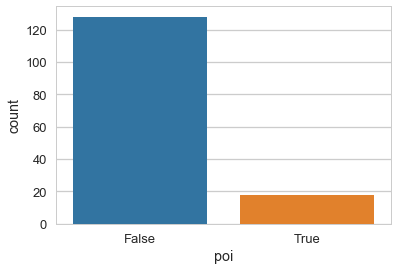

In [7]:
sns.set_context("talk")
sns.set_style("whitegrid")
sns.despine(left=True)
sns.countplot(x='poi',data=eron_data) 

Lets treat our missing data. In order to do so we will need to first see how many NaN are on our dataset by each feature.

In [8]:
def PercentageMissin(Dataset):
    """this function will return the percentage of missing values in a dataset """
    if isinstance(Dataset,pd.DataFrame):
        adict={} #a dictionary conatin keys columns names and values percentage of missin value in the columns
        for feature in Dataset.columns:
            count_nan_feature = 0;
            for feature_row in Dataset[feature]:
                if(feature_row == 'NaN'):
                    count_nan_feature += 1  
            adict[feature]=(count_nan_feature*100)/len(Dataset[feature])
        return pd.DataFrame(adict,index=['% of missing'],columns=adict.keys())
    else:
        raise TypeError("can only be used with panda dataframe")

In [9]:
print("Ranking of Missing Data")
PercentageMissin(eron_data).mean().sort_values(ascending=False)

Ranking of Missing Data


loan_advances                97.0
director_fees                88.0
restricted_stock_deferred    87.0
deferral_payments            73.0
deferred_income              66.0
long_term_incentive          54.0
bonus                        43.0
from_poi_to_this_person      41.0
from_messages                41.0
shared_receipt_with_poi      41.0
from_this_person_to_poi      41.0
to_messages                  41.0
other                        36.0
expenses                     34.0
salary                       34.0
exercised_stock_options      30.0
restricted_stock             24.0
email_address                23.0
total_payments               14.0
total_stock_value            13.0
poi                           0.0
dtype: float64

In [10]:
payment_fields =['poi','salary','bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
            'loan_advances', 'other','expenses', 'director_fees','total_payments']
stock_fields =['poi','exercised_stock_options','restricted_stock','restricted_stock_deferred','total_stock_value']
email_fields =['to_messages','from_messages','from_poi_to_this_person','from_this_person_to_poi','shared_receipt_with_poi']

In [11]:
eron_data.loc[:,payment_fields] = eron_data.loc[:,payment_fields].replace('NaN', 0)
eron_data.loc[:,stock_fields] = eron_data.loc[:,stock_fields].replace('NaN',0) 

In [12]:
eron_poi = eron_data[eron_data.poi == 1]
eron_non_poi = eron_data[eron_data.poi == 0]

In [13]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)

eron_poi.loc[:, email_fields] = imp.fit_transform(eron_poi.loc[:,email_fields]);
eron_non_poi.loc[:, email_fields] = imp.fit_transform(eron_non_poi.loc[:,email_fields]);

eron_data = eron_poi.append(eron_non_poi)

/Users/andreyai/anaconda/envs/bunnies/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
eron_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, BELDEN TIMOTHY N to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null int64
to_messages                  146 non-null float64
deferral_payments            146 non-null int64
total_payments               146 non-null int64
exercised_stock_options      146 non-null int64
bonus                        146 non-null int64
restricted_stock             146 non-null int64
shared_receipt_with_poi      146 non-null float64
restricted_stock_deferred    146 non-null int64
total_stock_value            146 non-null int64
expenses                     146 non-null int64
loan_advances                146 non-null int64
from_messages                146 non-null float64
other                        146 non-null int64
from_this_person_to_poi      146 non-null float64
poi                          146 non-null bool
director_fees                146 non-null int64
deferred_income              146 non-null int64
long_ter

There are no more missing data.

In [15]:
eron_data.head(20)['poi']

BELDEN TIMOTHY N         True
BOWEN JR RAYMOND M       True
CALGER CHRISTOPHER F     True
CAUSEY RICHARD A         True
COLWELL WESLEY           True
DELAINEY DAVID W         True
FASTOW ANDREW S          True
GLISAN JR BEN F          True
HANNON KEVIN P           True
HIRKO JOSEPH             True
KOENIG MARK E            True
KOPPER MICHAEL J         True
LAY KENNETH L            True
RICE KENNETH D           True
RIEKER PAULA H           True
SHELBY REX               True
SKILLING JEFFREY K       True
YEAGER F SCOTT           True
ALLEN PHILLIP K         False
BADUM JAMES P           False
Name: poi, dtype: bool

### Outliers

In this part we will find the outliers and remove them.

In [16]:
eron_data[eron_data[payment_fields[1:-1]].sum(axis='columns') != eron_data['total_payments']][payment_fields + ['total_payments']]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,total_payments
BELFER ROBERT,False,0,0,0,0,-102500,0,0,0,3285,102500,102500
BHATNAGAR SANJAY,False,0,0,0,0,0,0,137864,0,137864,15456290,15456290


In [17]:
eron_data[eron_data[stock_fields[1:-1]].sum(axis='columns') != eron_data['total_stock_value']][stock_fields+['total_stock_value']]

,poi,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,total_stock_value
BELFER ROBERT,False,3285,0,44093,-44093,-44093
BHATNAGAR SANJAY,False,2604490,-2604490,15456290,0,0


We see that only Belfer Robert and BHATNAGAR SANJAY had their data of total_payments and total_stock different from the payments_fields and stock_fields aggregate sum. Now looking at the eron pdf we can see that the values in the dataset were wrong. So we will now correct them.

Treating Belfer Robert.

In [18]:
# Belfer Robert
eron_data.loc['BELFER ROBERT','deffered_income'] = -102500
eron_data.loc['BELFER ROBERT','defferral_payments'] = 0
eron_data.loc['BELFER ROBERT','expenses'] = 3285
eron_data.loc['BELFER ROBERT','director_fees'] = 102500
eron_data.loc['BELFER ROBERT','total_payments'] = 3285

eron_data.loc['BELFER ROBERT','exercised_stock_options'] = 0
eron_data.loc['BELFER ROBERT','restricted_stock'] = 44093
eron_data.loc['BELFER ROBERT','restricted_stock_deferred'] = -44093
eron_data.loc['BELFER ROBERT','total_stock_value'] = 0

eron_data.loc['BELFER ROBERT'][payment_fields+stock_fields]

poi                            False
salary                             0
bonus                              0
long_term_incentive                0
deferred_income                    0
deferral_payments            -102500
loan_advances                      0
other                              0
expenses                        3285
director_fees                 102500
total_payments                  3285
poi                            False
exercised_stock_options            0
restricted_stock               44093
restricted_stock_deferred     -44093
total_stock_value                  0
Name: BELFER ROBERT, dtype: object

Treating BHATNAGAR SANJAY.

In [19]:
# BHATNAGAR SANJAY
eron_data.loc['BHATNAGAR SANJAY','other'] = 0
eron_data.loc['BHATNAGAR SANJAY','expenses'] = 137864
eron_data.loc['BHATNAGAR SANJAY','director_fees'] = 0
eron_data.loc['BHATNAGAR SANJAY','total_payments'] = 137864

eron_data.loc['BHATNAGAR SANJAY','exercised_stock_options'] = 15456290
eron_data.loc['BHATNAGAR SANJAY','restricted_stock'] = 2604490
eron_data.loc['BHATNAGAR SANJAY','restricted_stock_deferred'] = -2604490
eron_data.loc['BHATNAGAR SANJAY','total_stock_value'] = 15456290

eron_data.loc['BHATNAGAR SANJAY'][payment_fields+stock_fields]

poi                             False
salary                              0
bonus                               0
long_term_incentive                 0
deferred_income                     0
deferral_payments                   0
loan_advances                       0
other                               0
expenses                       137864
director_fees                       0
total_payments                 137864
poi                             False
exercised_stock_options      15456290
restricted_stock              2604490
restricted_stock_deferred    -2604490
total_stock_value            15456290
Name: BHATNAGAR SANJAY, dtype: object

In [20]:
eron_data[eron_data[payment_fields[1:-1]].sum(axis='columns') != eron_data['total_payments']][payment_fields]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments


In [21]:
eron_data[eron_data[stock_fields[1:-1]].sum(axis='columns') != eron_data['total_stock_value']][stock_fields]

,poi,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value


Fill all the incorrect data. Now lets see in the rows and their outliers and see if they are an oulier. 

### Removing Outliers

According to the pdf and the data_dict we have some aggregate row. They are "Total" and "THE TRAVEL AGENCY IN THE PARK". So lets remove them.

In [22]:
eron_data = eron_data.drop(["TOTAL","THE TRAVEL AGENCY IN THE PARK"])

Lets see those with rows with more outliers. To do so we will see the rows that stays less than 25% of the data
and those with greather than 75%.

In [23]:
outliers = eron_data.quantile(.5) + 1.5 * (eron_data.quantile(.75)-eron_data.quantile(.25))
outlier_pd = pd.DataFrame((eron_data[1:] > outliers[1:]).sum(axis = 1), columns = ['# of outliers']).\
    sort_values('# of outliers',  ascending = [0]).head(7)
outlier_pd

,# of outliers
LAY KENNETH L,14
FREVERT MARK A,12
WHALLEY LAWRENCE G,11
LAVORATO JOHN J,11
SKILLING JEFFREY K,9
KEAN STEVEN J,8
DELAINEY DAVID W,8


In [24]:
pd = outlier_pd.join(eron_data)
pd[['# of outliers','poi']]

,# of outliers,poi
LAY KENNETH L,14,True
FREVERT MARK A,12,False
WHALLEY LAWRENCE G,11,False
LAVORATO JOHN J,11,False
SKILLING JEFFREY K,9,True
KEAN STEVEN J,8,False
DELAINEY DAVID W,8,True


We will remove those with more outliers that are not poi.

In [25]:
eron_data_clean = eron_data.drop(['FREVERT MARK A','WHALLEY LAWRENCE G','LAVORATO JOHN J','KEAN STEVEN J'])
del data_dict['FREVERT MARK A']
del data_dict['WHALLEY LAWRENCE G']
del data_dict['LAVORATO JOHN J']
del data_dict['KEAN STEVEN J']

### Select Features

First thing that strike my attention was the number of missing data in loan_advances,director_fees, restricted_stock_deferred, deferral_payments. It seems we have just a few of those and I if it wll be usefull to our model.

In [26]:
loan_advances_df = eron_data[eron_data.loan_advances != 0][['loan_advances','poi']]
print("There are ",len(loan_advances_df)," points in our dataset.")
loan_advances_df

('There are ', 3, ' points in our dataset.')


,loan_advances,poi
LAY KENNETH L,81525000,True
FREVERT MARK A,2000000,False
PICKERING MARK R,400000,False


Since we gae only four poins in our dataset and only one is a poi so I will not consider this from our feature list.

In [27]:
director_fees_df = eron_data[eron_data.director_fees != 0][['director_fees','poi']]
print("There are ",len(director_fees_df)," points in our dataset.")
director_fees_df

('There are ', 15, ' points in our dataset.')


,director_fees,poi
BELFER ROBERT,102500,False
BLAKE JR. NORMAN P,113784,False
CHAN RONNIE,98784,False
DUNCAN JOHN H,102492,False
GRAMM WENDY L,119292,False
JAEDICKE ROBERT,108750,False
LEMAISTRE CHARLES,112492,False
MENDELSOHN JOHN,103750,False
MEYER JEROME J,38346,False
PEREIRA PAULO V. FERRAZ,101250,False


From 146 values we have only 17 entries and from those all 17 are false to poi parameter. So I will also not consider in my analysis. 

In [28]:
restricted_stock_deferred_df = eron_data[eron_data.restricted_stock_deferred != 0][['restricted_stock_deferred','poi']]
print("There are ",len(restricted_stock_deferred_df)," points in our dataset.")
restricted_stock_deferred_df

('There are ', 17, ' points in our dataset.')


,restricted_stock_deferred,poi
ALLEN PHILLIP K,-126027,False
BANNANTINE JAMES M,-560222,False
BAY FRANKLIN R,-82782,False
BELFER ROBERT,-44093,False
BHATNAGAR SANJAY,-2604490,False
CARTER REBECCA C,-307301,False
CHAN RONNIE,-32460,False
CLINE KENNETH W,-472568,False
DERRICK JR. JAMES V,-1787380,False
DETMERING TIMOTHY J,-315068,False


The same happened with restricted_store_deferred as with the director_fee. From 146 values we have only 18 entries and from those all are false to poi parameter. So I will also not consider in my analysis.

In [29]:
deferral_payments_df = eron_data[eron_data.deferral_payments != 0][['deferral_payments','poi']]
print("There are ",len(deferral_payments_df)," points in our dataset.")
deferral_payments_df

('There are ', 38, ' points in our dataset.')


,deferral_payments,poi
BELDEN TIMOTHY N,2144013,True
COLWELL WESLEY,27610,True
HIRKO JOSEPH,10259,True
LAY KENNETH L,202911,True
RIEKER PAULA H,214678,True
ALLEN PHILLIP K,2869717,False
BADUM JAMES P,178980,False
BAXTER JOHN C,1295738,False
BAY FRANKLIN R,260455,False
BAZELIDES PHILIP J,684694,False


In [30]:
deferral_payments_df.groupby('poi').count()

,deferral_payments
poi,
False,33
True,5


We found some poi in deferral payments!! There were 5 poi out of 39 people in this feature. Let see  if plotting the values we found some more information about this points.

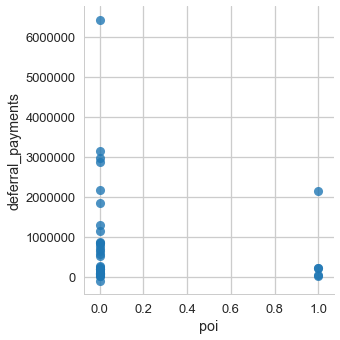

In [31]:
sns.lmplot('poi','deferral_payments',data=deferral_payments_df,fit_reg=False)

We also noticed that ther are no much difference between the values of poi and non poi for the deferral payments. Most of the poi felt almost like in the middle of the data.

The others features contain almost 50% of the data so I will use them in my analysis. Other thing is the email_address is unique amoung the people, so I will not use these variable.
The features loan_advances, directors_fees, restricted_stock_deffered and email_address will be use.

In [32]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = [
    'poi', 'to_messages','from_messages', 'from_poi_to_this_person','from_this_person_to_poi', 
    'salary','deferral_payments', 'other','total_payments','bonus', 
    'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive',
    'exercised_stock_options','deferred_income', 'expenses', 'restricted_stock']

# In the featureFormat it will treat the missing values giving them a 0  value
eron_data = eron_data[features_list]
data = eron_data
# data = featureFormat(data_dict, features_list)


#### Question: 
Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]

#### Answer:

The goal of this project is to succesfully identify the POIs of the Eron scandal. In order to do it I will use machine learning classify algorithm, that can throught the data identify patterns of the POI. In this project I will use the dataset contaning some financial data and  email data.

### Optimize Feature Selection/Engineering:
- Create new features (related lesson: "Feature Selection"): 

At least one new feature is implemented. Justification for that feature is provided in the written response. The effect of that feature on final algorithm performance is tested or its strength is compared to other features in feature selection. The student is not required to include their new feature in their final feature set.

- Intelligently select features (related lesson: "Feature Selection"):

Univariate or recursive feature selection is deployed, or features are selected by hand (different combinations of features are attempted, and the performance is documented for each one). Features that are selected are reported and the number of features selected is justified. For an algorithm that supports getting the feature importances (e.g. decision tree) or feature scores (e.g. SelectKBest), those are documented as well.

- Properly scale features (related lesson: "Feature Scaling")

If algorithm calls for scaled features, feature scaling is deployed.
   

###### Creating new features

In [33]:
eron_data[eron_data['to_messages'] < eron_data['from_poi_to_this_person']][['from_poi_to_this_person', 'to_messages']]

,from_poi_to_this_person,to_messages


In [34]:
eron_data[eron_data['from_messages'] < eron_data['from_this_person_to_poi']][['from_this_person_to_poi', 'from_messages']]

,from_this_person_to_poi,from_messages


In [35]:
# Engineer a new feature
eron_data['fraction_messages_to_poi'] =eron_data['from_this_person_to_poi']/eron_data['from_messages']
eron_data['fraction_messages_from_poi'] = eron_data['from_poi_to_this_person']/eron_data['to_messages']

In [36]:
print(eron_data.loc['BANNANTINE JAMES M'])

poi                               False
to_messages                         566
from_messages                        29
from_poi_to_this_person              39
from_this_person_to_poi               0
salary                              477
deferral_payments                     0
other                            864523
total_payments                   916197
bonus                                 0
total_stock_value               5243487
shared_receipt_with_poi             465
long_term_incentive                   0
exercised_stock_options         4046157
deferred_income                   -5104
expenses                          56301
restricted_stock                1757552
fraction_messages_to_poi              0
fraction_messages_from_poi    0.0689046
Name: BANNANTINE JAMES M, dtype: object


In [37]:
new_features = ["fraction_messages_from_poi","fraction_messages_to_poi"]

for feature_name in new_features:
    if feature_name  not in features_list:
        features_list.append(feature_name)

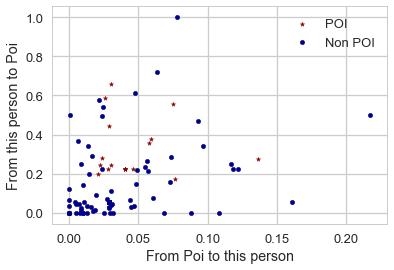

In [38]:
### plot new features
fraction_list = ['poi','fraction_messages_from_poi','fraction_messages_to_poi']
data_fraction = eron_data[fraction_list]

data_fraction_poi = data_fraction[data_fraction['poi'] == 1]
data_fraction_non_poi = data_fraction[data_fraction['poi'] == 0]

ax = data_fraction_poi.plot(kind='scatter', x='fraction_messages_from_poi', y='fraction_messages_to_poi',
             color='DarkRed', label='POI', marker="*");
data_fraction_non_poi.plot(kind='scatter', x='fraction_messages_from_poi', y='fraction_messages_to_poi',
             color='DarkBlue', label='Non POI',ax=ax);

plt.ylabel("From this person to Poi")
plt.xlabel('From Poi to this person')
plt.show()

Get my dataset and alseo perform feature scalling

In [39]:
from sklearn.preprocessing import scale
def get_mydataset(df):
    
    scaled_df = df.copy()
    scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])
    my_dataset = scaled_df.to_dict(orient='index')

    return my_dataset

my_dataset = get_mydataset(eron_data)

### Feature selection

In [40]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
print("Initial data shape:", data.shape)
print("Feature_list:", features_list)

('Initial data shape:', (144, 19))
('Feature_list:', ['poi', 'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'salary', 'deferral_payments', 'other', 'total_payments', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive', 'exercised_stock_options', 'deferred_income', 'expenses', 'restricted_stock', 'fraction_messages_from_poi', 'fraction_messages_to_poi'])


In [41]:
features = np.array(features)
data.shape,features.shape

((144, 19), (144, 18))

In [42]:
import numpy as np
import pandas as pd 
data_pd = pd.DataFrame(data=data)
corr = data_pd.corr()

In [43]:
corr.shape

(19, 19)

In [44]:
# Feature selection - selectionkbest, select percentile,lasso regression
from sklearn.feature_selection import SelectPercentile,SelectKBest,chi2

selector = SelectKBest(k=5)
new_data = selector.fit_transform(features,labels)
scores_KB = selector.scores_

print("Final shape of parameters",new_data.shape)
print("Feature scores:",selector.scores_)
                                                                                                                                                                                                                   

('Final shape of parameters', (144, 5))
('Feature scores:', array([  0.66550106,   1.05946406,   5.52306534,   2.46535861,
        18.57570327,   0.21705893,   4.26115619,   9.38767236,
        21.06000171,  22.78210783,  10.49345475,  10.07245453,
        22.61053071,  11.59554766,   5.55068378,   8.95854005,
         2.62649425,  26.17856024]))


In [45]:
import numpy as np

scores = selector.scores_
print(scores)
indices = np.argsort(scores)[::-1]
print(indices)
print 'Feature Ranking'
for i in range(len(scores)-1): 
    print "{} feature {} ({})".format(i+1,features_list[indices[i]+1],scores[indices[i]])

[  0.66550106   1.05946406   5.52306534   2.46535861  18.57570327
   0.21705893   4.26115619   9.38767236  21.06000171  22.78210783
  10.49345475  10.07245453  22.61053071  11.59554766   5.55068378
   8.95854005   2.62649425  26.17856024]
[17  9 12  8  4 13 10 11  7 15 14  2  6 16  3  1  0  5]
Feature Ranking
1 feature fraction_messages_to_poi (26.1785602448)
2 feature total_stock_value (22.7821078297)
3 feature exercised_stock_options (22.6105307069)
4 feature bonus (21.0600017075)
5 feature salary (18.575703268)
6 feature deferred_income (11.5955476597)
7 feature shared_receipt_with_poi (10.4934547511)
8 feature long_term_incentive (10.0724545294)
9 feature total_payments (9.38767235578)
10 feature restricted_stock (8.95854004908)
11 feature expenses (5.55068377573)
12 feature from_poi_to_this_person (5.52306533919)
13 feature other (4.26115619074)
14 feature fraction_messages_from_poi (2.6264942501)
15 feature from_this_person_to_poi (2.46535861225)
16 feature from_messages (1.05946

I used SelectBestK with k = 5. Then I stayed with the top 5 features: ['fraction_messages_to_poi','salary','total_stock_value','bonus','exercised_stock_options'].

#### Question: 
What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]


#### Answer

I end up using in my POI identifier the features ['fraction_messages_to_poi','salary','total_stock_value','bonus','exercised_stock_options'] to select them I used the SelectKBest with k=5. I used scalling before the feature selection. I used selection in order to better scale the financial features. I created two new variables fraction of emails received from POI and fraction of emails sent to poi.  

## Pick an Algorithm

- Pick an algorithm (related lessons: "Naive Bayes" through "Choose Your Own Algorithm")

At least two different algorithms are attempted and their performance is compared, with the best performing one used in the final analysis.


Let's first separate between train and test data set.

In [46]:
# Train and test
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [47]:

def test_model_tester(clf,my_dataset,featurs_list):
    """
        This function will test our model into the tester file
    """
    tester.dump_classifier_and_data(clf, my_dataset, features_list)
    return tester.main()


Then we will peak an algorithm.
I will try to fit with:
    - Knn
    - Decision Tree
    - Random Forest
    - Ada Boost

In [48]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
test_model_tester(clf,my_dataset,features_list)

GaussianNB(priors=None)
	Accuracy: 0.83907	Precision: 0.36163	Recall: 0.27050	F1: 0.30950	F2: 0.28486
	Total predictions: 15000	True positives:  541	False positives:  955	False negatives: 1459	True negatives: 12045



In [49]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
test_model_tester(clf,my_dataset,features_list)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
	Accuracy: 0.86640	Precision: 0.49595	Recall: 0.12250	F1: 0.19647	F2: 0.14422
	Total predictions: 15000	True positives:  245	False positives:  249	False negatives: 1755	True negatives: 12751



In [50]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)

predict = clf.predict(features_test)

In [51]:
test_model_tester(clf,my_dataset,features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.89887	Precision: 0.62069	Recall: 0.62100	F1: 0.62084	F2: 0.62094
	Total predictions: 15000	True positives: 1242	False positives:  759	False negatives:  758	True negatives: 12241



In [52]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=110)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
test_model_tester(clf,my_dataset,features_list)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=110, random_state=None)
	Accuracy: 0.88453	Precision: 0.58111	Recall: 0.48000	F1: 0.52574	F2: 0.49731
	Total predictions: 15000	True positives:  960	False positives:  692	False negatives: 1040	True negatives: 12308



In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(features_train,labels_train)
predict = clf.predict(features_test)
test_model_tester(clf,my_dataset,features_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.89520	Precision: 0.74318	Recall: 0.32700	F1: 0.45417	F2: 0.36824
	Total predictions: 15000	True positives:  654	False positives:  226	False negatives: 1346	True negatives: 12774



#### Question:
What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?  [relevant rubric item: “pick an algorithm”]

#### Answer:

I tried to use knn, naive bayes, decision trees and some ensembles classifiers like adaboost and random forest. I noticed that the perfomace differ from one model to another and with the decision tree it had the best peformace, with Accuracy: 0.89740 Precission: 0.61636	Recall: 0.61050  I also noticed that with AdaBoost I had a great metrics results as well. 

## Tune an Algorithm

- Discuss parameter tuning and its importance.:

Response addresses what it means to perform parameter tuning and why it is important.

- Tune the algorithm (related lesson: "Validation"):

At least one important parameter tuned with at least 3 settings investigated systematically, or any of the following are true:

GridSearchCV used for parameter tuning
Several parameters tuned
Parameter tuning incorporated into algorithm selection (i.e. parameters tuned for more than one algorithm, and best algorithm-tune combination selected for final analysis).


- Algorithm Performance

When tester.py is used to evaluate performance, precision and recall are both at least 0.3.

- Validation Strategy (related lesson "Validation")

Performance of the final algorithm selected is assessed by splitting the data into training and testing sets or through the use of cross validation, noting the specific type of validation performed. 


In [62]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV

def init_cross_validation(train_reduced, labels):
    
    cross_validation = StratifiedKFold(n_splits=5)
    cross_validation.get_n_splits(train_reduced, labels)
    
    return cross_validation;

def generate_grid_search_model(model,parameters,train_reduced,labels):
    
    cross_validation = init_cross_validation(train_reduced, labels);
    
    grid_search = GridSearchCV(model,
                               scoring='accuracy',
                               param_grid = parameters,
                               cv = cross_validation)

    grid_search.fit(train_reduced, labels)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
    return model

In [76]:
def create_decision_tree(train_reduced,labels,run_grid_search=False):
    
    if run_grid_search:
        
        parameter_grid = {
            'min_samples_split': [2, 3,4, 10],
            'min_samples_leaf': [1, 3, 10]
        }
        clf = DecisionTreeClassifier()
        clf = generate_grid_search_model(clf,parameter_grid,train_reduced,labels)
    else: 
        parameters = {
            class_weight:None,
            criterion:'gini', 
            max_depth:None,
            max_features:None, 
            max_leaf_nodes:None,
            min_impurity_split:1e-07, 
            min_samples_leaf:1,
            min_samples_split:2, 
            min_weight_fraction_leaf:0.0,
            presort:False, 
            random_state:None,
            splitter:'best'
        }
        clf = DecisionTreeClassifier(**parameters)
        clf.fit(train_reduced, labels)

    return clf

In [71]:
def create_AdaBoost(train_reduced,labels,run_grid_search=False):
    
    if run_grid_search:
        
        parameter_grid = {
            'n_estimators': [100,110,120,130,150,170]
        }
        clf = AdaBoostClassifier()
        clf = generate_grid_search_model(clf,parameter_grid,train_reduced,labels)
    else: 
        parameters = {
            'n_estimators': 130
        }

        clf = AdaBoostClassifier(**parameters)
        clf.fit(train_reduced, labels)

    return clf

In [82]:
clfAda = create_AdaBoost(features,labels,run_grid_search=True)

Best score: 0.902777777778
Best parameters: {'n_estimators': 110}


In [83]:
test_model_tester(clfAda,my_dataset,features_list)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 110, 120, 130, 150, 170]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
	Accuracy: 0.88607	Precision: 0.58792	Recall: 0.48650	F1: 0.53242	F2: 0.50388
	Total predictions: 15000	True positives:  973	False positives:  682	False negatives: 1027	True negatives: 12318



In [80]:
clfDT =  create_decision_tree(features,labels,run_grid_search=True)
test_model_tester(clfDT,my_dataset,features_list)

Best score: 0.916666666667
Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 1}
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
	Accuracy: 0.89400	Precision: 0.61402	Recall: 0.55200	F1: 0.58136	F2: 0.56338
	Total predictions: 15000	True positives: 1104	False positives:  694	False negatives:  896	True negatives: 12306



#### Question
What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric items: “discuss parameter tuning”, “tune the algorithm”]

#### Answer:

Tuning the algorithm means finding the best parameters for a certain model, that gives a better results. 
I tuned my particular algorithm for the Decision Tree and got {'max_features': 'auto', 'min_samples_split': 3, 'max_depth': 6, 'min_samples_leaf': 3} parameters. For my Adaboost model I tuned the n_estimators. And the final result was 'n_estimators': 130

### Validate and Evaluate
- Usage of Evaluation Metrics (related lesson: "Evaluation Metrics")
	
At least two appropriate metrics are used to evaluate algorithm performance (e.g. precision and recall), and the student articulates what those metrics measure in context of the project task.

- Discuss validation and its importance.

Response addresses what validation is and why it is important.


Evaluate

In [86]:
test_model_tester(clfDT,my_dataset,features_list)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 10], 'min_samples_leaf': [1, 3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
	Accuracy: 0.89320	Precision: 0.61031	Recall: 0.55050	F1: 0.57886	F2: 0.56151
	Total predictions: 15000	True positives: 1101	False positives:  703	False negatives:  899	True negatives: 12297



#### Question
What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric items: “discuss validation”, “validation strategy”]

#### Answer:

Validation process is when you divided your dataset into train, test datasets. A classic mistake is to not divide into these to dataset and use the entire data to train your model. I validade my model using a croess-validation (that means dividing my dataset into small chucks and using most of them to train and a chuck to test and then repeat the process).To validate my model I used a  k-fold = 5.

#### Question: 

Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]

#### Answer:

And also to validate I used the accuracy, reacall and prediction socer. In my final model I got Accuracy Score: 100% Recall Score: 100% Precision Score: 100%.

## Exporting Model

In [87]:

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.


dump_classifier_and_data(clfDT, my_dataset, features_list)

NameError: name 'dump_classifier_and_data' is not defined